<a href="https://colab.research.google.com/github/pandian-ra/EVA4_Session6/blob/master/Final_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import random
from torch.autograd import Variable
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import json

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-5.0, 5.0), fill=(1,)),                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        
        # CONVOLUTION BLOCK 2
        self.convblock22 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=22, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(22),
            nn.Dropout(dropout_value)
        ) # output_size = 4


        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 3
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock22(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             160
           Conv2d-11           [-1, 10, 10, 10]             900
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
          Dropout-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06394637376070023 Batch_id=468 Accuracy=90.28: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.028612608090043068 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.054832518100738525 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Loss=0.022182822227478027 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9909/10000 (99.09%)

EPOCH: 4


Loss=0.0296553373336792 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:20<00:00, 23.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.05458926782011986 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.03052196092903614 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.05367449298501015 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.04416349530220032 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 23.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.05135982856154442 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.06328091770410538 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:19<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.09199037402868271 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.011274759657680988 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.07544834166765213 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.01213796902447939 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:19<00:00, 28.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.042095232754945755 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9915/10000 (99.15%)

EPOCH: 16


Loss=0.01930146850645542 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:19<00:00, 24.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.025444364175200462 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

EPOCH: 18


Loss=0.01895616389811039 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.006827369332313538 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Loss=0.04957042261958122 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:19<00:00, 23.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 21


Loss=0.04436861351132393 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:19<00:00, 24.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.0130712715908885 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:19<00:00, 24.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.08722230792045593 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.04937247559428215 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 23.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.015643199905753136 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 26


Loss=0.0020434458274394274 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

EPOCH: 27


Loss=0.03449856862425804 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 28


Loss=0.07499424368143082 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:19<00:00, 24.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 29


Loss=0.029093308374285698 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 30


Loss=0.008768603205680847 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.07760407030582428 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9946/10000 (99.46%)

EPOCH: 32


Loss=0.027725597843527794 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.1050730049610138 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:19<00:00, 23.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.014416788704693317 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 35


Loss=0.007191712502390146 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.07836596667766571 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:19<00:00, 24.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 37


Loss=0.04086761549115181 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 38


Loss=0.007881482131779194 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

EPOCH: 39


Loss=0.04323916137218475 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 30.53it/s]



Test set: Average loss: 0.0170, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

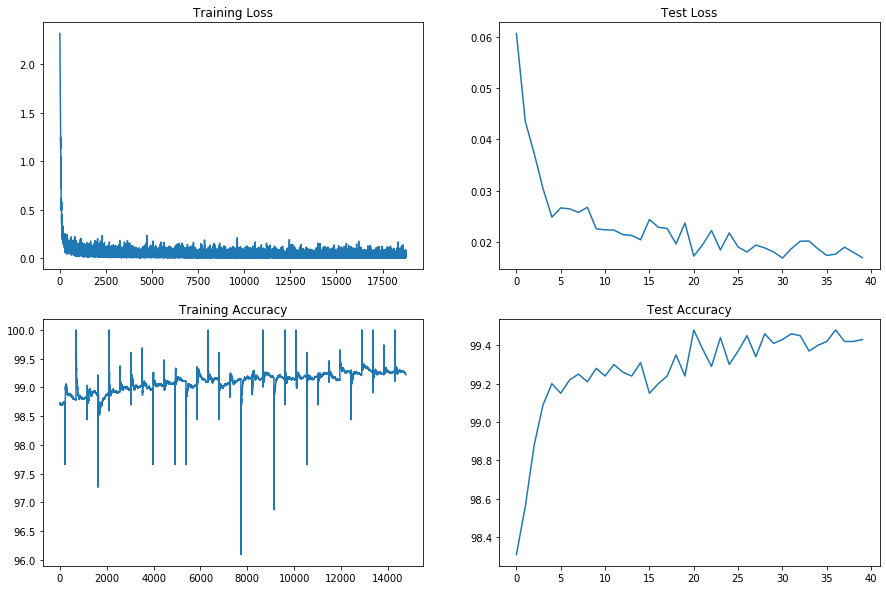

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import json

with open('test_acc_Without_REG.txt', 'w') as filehandle:
    json.dump(test_acc, filehandle)

In [0]:
import json

with open('test_losses_Without_REG.txt', 'w') as filehandle:
    json.dump(test_losses, filehandle)

In [0]:
torch.save(model.state_dict(), 'Without_REG_40E.pt')


In [0]:
criterion = nn.CrossEntropyLoss()
batch_size = 128

In [0]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [0]:
def wrong_plot(true,ima,pred,encoder,inv_normalize,n_figures ):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/5)
    fig,axes = plt.subplots(figsize=(10, 10), nrows = n_row, ncols=5)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+str(c.item()) + ',' +'P:'+str(w.item())
        f = 'A:'+str(correct) + ',' +'P:'+str(wrong)
        # image = image.numpy().transpose(1,2,0)
        image = image.squeeze()
        im = ax.imshow(image, cmap='gray', interpolation='none')
        ax.set_title(f)
        ax.axis('off')
    plt.show()

In [20]:
true,pred,image,true_wrong,pred_wrong = test(test_loader)

tensor(0.9833, device='cuda:0', dtype=torch.float64) 0.016784246538285332


Classes in order Actual and Predicted


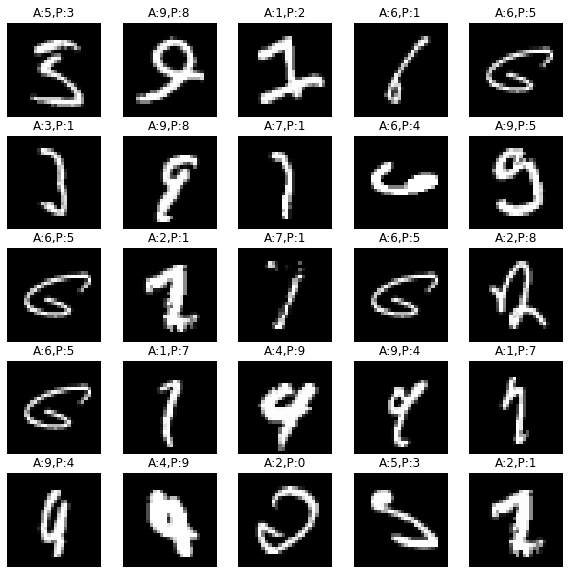

In [21]:
wrong_plot(true_wrong,image,pred_wrong,test_loader.dataset.targets,None,25)